In [1]:
# google-drive-ocamlfuseのインストール
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colab用のAuth token作成
from google.colab import auth
auth.authenticate_user()

# Drive FUSE library用のcredential生成
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# drive/ を作り、そこにGoogle Driveをマウントする
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [2]:
#Install Chainer and CuPy!

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip install 'chainer==4.0.0b3'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 1s (16.3 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 19833 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###..

    100% |████████████████████████████████| 205.2MB 186kB/s 
    100% |████████████████████████████████| 81kB 2.6MB/s 
    100% |████████████████████████████████| 368kB 4.8MB/s 
  Running setup.py bdist_wheel for chainer ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/7a/e7/26/c13ce14e84f7f2a7209a31f5a1e327b8c681c5bcb3abcd0bec
  Running setup.py bdist_wheel for filelock ... - done
  Stored in directory: /content/.cache/pip/wheels/35/ba/67/4cc48738870c3b54f9e3b5d78bf9de130befb70c1d359faf8b
Successfully built chainer filelock


In [3]:
!git clone git://github.com/TeamPMG/CGG-Learning

Cloning into 'CGG-Learning'...
remote: Counting objects: 2354, done.
remote: Total 2354 (delta 0), reused 0 (delta 0), pack-reused 2354
Receiving objects: 100% (2354/2354), 419.18 MiB | 41.91 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [4]:
%cd CGG-Learning

/content/CGG-Learning


In [0]:
#!git clone git://github.com/TeamPMG/train_images

In [6]:
#setup

import numpy as np
import chainer
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L
from chainer import serializers,cuda

import math
import os
import glob
import pickle
from PIL import Image

import sys
from IPython.display import display_png

#from network import generator,discriminator
#from network2 import generator,discriminator

DRIVE_PATH = "drive/"
TRAIN_IMAGE_PATH = "../" + DRIVE_PATH + "prepared/*" 
GENERATED_IMAGE_PATH = "./generated/" 

BATCH_SIZE = 16
NUM_EPOCH = 200
DIM = 3
NUMBER_OF_TAG = 1539
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

#GPU_set
gpu_device = 0
cuda.get_device(gpu_device).use()
xp = cuda.cupy

#xp = np

/usr/local/lib/python3.6/dist-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


GPU availability: True
cuDNN availablility: True


In [0]:
#network

class EqualizedConv2d(chainer.Chain):
    def __init__(self, in_dim, out_dim,ksize=3,stride=1,pad=1):
        w = chainer.initializers.Normal(1.0) # equalized learning rate
        self.inv_c = np.sqrt(2.0/(in_dim*ksize**2))
        super(EqualizedConv2d,self).__init__(
            normalize=normalize(),
        )
        with self.init_scope():
            self.c1=L.Convolution2D(in_dim, out_dim, ksize, stride, pad, initialW=w)
    def __call__(self,x,normalize = True,dropout = False):
        h = self.c1(x * self.inv_c)
        
        if normalize:
            h = self.normalize(h)
        
        if dropout:
          F.dropout(h)
        return h
            
class EqualizedLinear(chainer.Chain):
    def __init__(self, in_dim, out_dim):
        w = chainer.initializers.Normal(1.0) # equalized learning rate
        self.inv_c = np.sqrt(2.0/(in_dim))
        super(EqualizedLinear,self).__init__(
        )
        with self.init_scope():
            self.l1=L.Linear(in_dim, out_dim, initialW=w)
    def __call__(self,x):
        h = self.l1(x * self.inv_c)
        return h

class g_block(chainer.Chain):
    def __init__(self, in_dim, out_dim):
        super(g_block,self).__init__(
            normalize=normalize(),
            dc1=EqualizedConv2d(in_dim, out_dim, 3, stride=1, pad=1),
            dc2=EqualizedConv2d(out_dim, out_dim, 3, stride=1, pad=1),
            to_RGB=EqualizedConv2d(out_dim, 3, 1, stride=1, pad=0),
        )
    def __call__(self,x,to_rgb=False):
        h = F.unpooling_2d(x, 2, 2, 0, outsize=(x.shape[2]*2, x.shape[3]*2))
        h = F.leaky_relu(self.dc1(h))
        h = F.leaky_relu(self.dc2(h))
        if to_rgb:
            #h = F.tanh(self.to_RGB(h))
            h = self.to_RGB(h,False)
        return h
      
class normalize(chainer.Chain):
    def __init__(self):
        super(normalize,self).__init__(
        )
    def __call__(self,x):
        eps = 1e-8
        mean=F.mean(x ** 2,axis=1,keepdims=True)
        mean=F.sqrt(mean + eps)
        mean = F.broadcast_to(mean, (x.shape))
        h = x / mean
        return h

class generator(chainer.Chain):
    def __init__(self, width, height, z_size):
        dims = [64, 64, 64, 64, 64, 64, 64, 64]
        super(generator,self).__init__(
            normalize=normalize(),
            c0 = EqualizedConv2d(z_size, dims[0], 4, stride=1, pad=3),
            c1 = EqualizedConv2d(dims[0], dims[0], 3, stride=1, pad=1),

            b0=g_block(dims[0],dims[1]),
            b1=g_block(dims[1],dims[2]),
            b2=g_block(dims[2],dims[3]),
            b3=g_block(dims[3],dims[4]),
            b4=g_block(dims[4],dims[5]),
            b5=g_block(dims[5],dims[6]),
            b6=g_block(dims[6],dims[7]),
            
            to_RGB=EqualizedConv2d(dims[0], 3, 1, stride=1, pad=0),

        )     

    def __call__(self, noise, tag,depth,alpha):
        h = F.reshape(noise,(len(noise),-1,1,1))
        h = F.leaky_relu(self.c0(h))
        h = F.leaky_relu(self.c1(h))
        
        for i in range(depth-1):
            h = getattr(self, "b%d" % i)(h)
            
        if 0<depth and alpha < 1:
            h2 = getattr(self, "b%d" % (depth-1))(h,True)
            if depth==1:
                #h = F.tanh(self.to_RGB(h))
                h = self.to_RGB(h,False)
            else:
                h = getattr(self, "b%d" % (depth-2)).to_RGB(h,False)
            h=F.unpooling_2d(h, 2, 2, 0, outsize=(2*h.shape[2], 2*h.shape[3]))
            
            h=h*(1.0-alpha)+h2*alpha
        elif depth == 0:
            #h = F.tanh(self.to_RGB(h))
            h = self.to_RGB(h,False)
        else:
            h = getattr(self, "b%d" % (depth-1))(h,True)
        
        #h = F.minimum(h,xp.ones(h.shape).astype(np.float32))
        #h = F.maximum(h,-1 * xp.ones(h.shape).astype(np.float32))

        return h

    
class d_block(chainer.Chain):
    def __init__(self, in_dim, out_dim):
        super(d_block,self).__init__(
            c1=EqualizedConv2d(in_dim, in_dim, 3, stride=1, pad=1),
            c2=EqualizedConv2d(in_dim, out_dim, 3, stride=1, pad=1),
            from_RGB=EqualizedConv2d(3, in_dim, 1, stride=1, pad=0), 
        )

    def __call__(self,x,rgb=False):
        h = x
        if rgb:
          h=F.leaky_relu(self.from_RGB(h,False))
        h=F.leaky_relu(self.c1(h,False,dropout = False))
        h=F.leaky_relu(self.c2(h,False,dropout = False))
            
        h=F.average_pooling_2d(h, 2, 2)   
        return h

class std(chainer.Chain):
    def __init__(self):
        super(std,self).__init__(
        )
    def __call__(self,x):
        mean=F.mean(x,axis=0)
        dev=x-F.broadcast_to(mean, x.shape)
        devdev=dev*dev
        var=F.mean(devdev)
        new_channel = F.broadcast_to(var, (x.shape[0], 1, x.shape[2], x.shape[3]))
        h = F.concat((x, new_channel), axis=1)
        return h


    
class discriminator(chainer.Chain):
    def __init__(self,dim):
        dims = [64, 64, 64, 64, 64, 64, 64, 64]
        super(discriminator,self).__init__(
            b0=d_block(dims[0],dims[1]),
            b1=d_block(dims[1],dims[2]),
            b2=d_block(dims[2],dims[3]),
            b3=d_block(dims[3],dims[4]),
            b4=d_block(dims[4],dims[5]),
            b5=d_block(dims[5],dims[6]),
            b6=d_block(dims[6],dims[7]),
            from_RGB=EqualizedConv2d(3, dims[7], 1, stride=1, pad=0),
            
            c1=EqualizedConv2d(dims[7] + 1, dims[7], 3, stride=1, pad=1),
            c2=EqualizedConv2d(dims[7], dims[7], 4, stride=1, pad=0),
  
            l4l = EqualizedLinear(dims[7], 1),
            std=std()
        )
        


    def __call__(self, image, tag,depth,alpha):
        h = image
        if depth == 0:
              h = F.leaky_relu(self.from_RGB(h,False))
        if 0<depth:
            h2 = getattr(self, "b%d" % (7-depth))(h,True)
            h = F.average_pooling_2d(h, 2, 2)
            if depth == 1:
              h = F.leaky_relu(self.from_RGB(h,False))
            else:
              h = F.leaky_relu(getattr(self, "b%d" % (7-depth + 1)).from_RGB(h,False))
            h=h*(1-alpha)+h2*alpha
            

        for i in range(depth-1):
            h = getattr(self, "b%d" % (7-depth+i+1))(h)

        h=self.std(h)
        h = F.leaky_relu(self.c1(h,False,dropout = False))
        h = F.leaky_relu(self.c2(h,False,dropout = False))
        
        l = self.l4l(h)

        return l



In [0]:
#utility

class DelGradient(object):
    name = 'DelGradient'
    def __init__(self, delTgt):
        self.delTgt = delTgt

    def __call__(self, opt):
        for name,param in opt.target.namedparams():
            for d in self.delTgt:
                if d in name:
                    grad = param.grad
                    with cuda.get_device(grad):
                        grad = 0
                        
def check_accuracy(model, xs, ts):
    ys = model(xs)
    loss = F.softmax_cross_entropy(ys, ts)
    ys = np.argmax(ys.data, axis=1)
    cors = (ys == ts)
    num_cors = sum(cors)
    accuracy = num_cors / ts.shape[0]
    return accuracy, loss

def data_import(width,height):
    try:
        with open("../" + DRIVE_PATH + 'images%d.pickle'%width, 'rb') as f:
            image = pickle.load(f)
            print("image load from pickle")
    except:
        image = np.empty((0,height,width,DIM), dtype=np.uint8)
        list=sorted(glob.glob(TRAIN_IMAGE_PATH))
        for i in list:
            im_reading = Image.open(i)
            im_reading .thumbnail((width, height),Image.ANTIALIAS)
            #print(im_reading.size)
            bg = Image.new("RGBA",[width,height],(255,255,255,255))
            bg.paste(im_reading,(int((width-im_reading.size[0])/2),int((height-im_reading.size[1])/2)))
            im_reading=bg.copy()
            #im_reading.show()
            
            if im_reading.mode=="RGB":
                im_reading = np.array(im_reading)
                
            else: 
                im_reading = im_reading.convert("RGB")
                im_reading = np.array(im_reading)
                for j in range(len(im_reading)):
                    for k in range(len(im_reading[0])):
                        if np.all(im_reading[j][k]==[71,112,76]) or np.all(im_reading[j][k]==[0,0,0]) or np.all(im_reading[j][k]==[76,105,113]):
                            im_reading[j][k]=[255,255,255]
    
                                  
                            #RGB (71,112,76),(75,105,113)のための例外処理。なんかいい方法があったら言ってくれ

            print(i)
            
            #im_reading = im_reading.transpose(1,0,2)
            #print(im_reading.shape)
            image = np.append(image, [im_reading], axis=0)
        
        with open("../" + DRIVE_PATH + 'images%d.pickle'%width, 'wb') as f:
            pickle.dump(image,f) 
        print("new image")
    try:
        with open('tags.pickle', 'rb') as f:
            estimated_tags = pickle.load(f)
            print("load from pickle")
        
    except:
        
        try:
            with open('illust2vec.pickle', 'rb') as f:
                illust2vec = pickle.load(f)
                print("pickle i2v")
        except:
            illust2vec = i2v.make_i2v_with_chainer(
            "./i2v/illust2vec_tag_ver200.caffemodel", "./i2v/tag_list.json")
            with open('illust2vec.pickle', 'wb') as f:
                pickle.dump(illust2vec,f)
            print("new i2v")
        
        batch_size=5
        estimated_tags=np.zeros((0,NUMBER_OF_TAG))
        for i in range(math.floor(len(image)/batch_size+1)):
            print(str(i)+"/"+str(math.floor(len(image)/batch_size+1)))
            if len(image)<batch_size*(i+1):
                batch=np.array(image[batch_size*i:])
            else:
                batch=np.array(image[batch_size*i:batch_size*(i+1)])
            print(estimated_tags.shape)
            
            estimated_tags=np.append(estimated_tags,illust2vec.extract_feature(batch),axis=0) 
            
        with open('tags.pickle', 'wb') as f:
            pickle.dump(estimated_tags,f)

    return image,estimated_tags

def combine_images(generated_images):
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    width, height = generated_images.shape[1:3]
    combined_image = np.zeros((width*cols, height*rows,DIM),
                              dtype=generated_images.dtype)
    #coreturn combined_image

    for index, image in enumerate(generated_images):
        i = index % cols
        j = int(index/cols)
        combined_image[width*i:width*(i+1), height*j:height*(j+1),0:3] = image[:,:,0:3 ]
    return combined_image
    
def save_images(images,file_name):
    if not os.path.exists(GENERATED_IMAGE_PATH):
                    os.mkdir(GENERATED_IMAGE_PATH)
    Image.fromarray(images.astype(np.uint8))\
        .save(GENERATED_IMAGE_PATH+"%s.png" % (file_name))
    display_png((Image.fromarray(images.astype(np.uint8))))

def save_generated_image(image,name):
    image = cuda.to_cpu(image)
    Imag=combine_images(image)
    save_images(Imag,name)
    
from scipy.ndimage.interpolation import rotate
from scipy.misc import imresize

def random_rotation(image, angle_range=(-10,10)):
  
    h, w, _ = image.shape
    angle = np.random.randint(*angle_range)
    image = rotate(image, angle)
    cond_p = (image[..., 0] == 0) & (image[..., 1] == 0) & (image[..., 2] == 0)
    image[cond_p] = [255, 255, 255]
    image = imresize(image, (h, w))
    
    return image
  
def horizontal_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[:, ::-1, :]
    return image
  
def data_augmentation(images):
  for i in range(len(images)):
    images[i] = horizontal_flip(images[i] , rate=0.5)
    #images[i] = random_rotation(images[i] , angle_range=(-1, 1))
  return images

In [0]:
#train_function

def train(depth = 0,start_alpha=0,g_learn_rate = 0.001,d_learn_rate = 0.001,gp_rate = 10):
    z_size = 128
    #model_set
    g = generator(512, 512, z_size)
    try:
        serializers.load_npz("../" + DRIVE_PATH + "generator.model", g)
        print("generator loaded")
    except:
        pass
      
    d = discriminator(128)
    try:
        serializers.load_npz("../" + DRIVE_PATH + "discriminator.model", d)
        print("discriminator loaded")
    except:
        pass
    
    #g_optimizer
    g_opt = chainer.optimizers.Adam(alpha=d_learn_rate, beta1=0.0, beta2=0.99)
    g_opt.setup(g)
    
    #d_optimizer
    d_opt = chainer.optimizers.Adam(alpha=g_learn_rate, beta1=0.0, beta2=0.99)
    d_opt.setup(d)

    #to_GPU
    g.to_gpu(gpu_device)
    d.to_gpu(gpu_device)
    
    #data_load
    X_train,tags = data_import(4*(2**depth),4*(2**depth))

    #tags = np.zeros((X_train[-1].shape[0],NUMBER_OF_TAG))
    tags = tags.astype(np.float32)


    num_batches = int(X_train.shape[0] / BATCH_SIZE)
    alpha=start_alpha
    NOISE = xp.random.normal(0, 0.5, [BATCH_SIZE,z_size])
    for epoch in range(NUM_EPOCH):
        for index in range(num_batches):
            #alpha_set
            if alpha + BATCH_SIZE / 400000<1.0:
                alpha=alpha +  BATCH_SIZE / 800000
            else:
              alpha = 1
            
            #tag
            tag_batch=tags[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            tag_batch = cuda.to_gpu(tag_batch, device=None, stream=None)
            
            #image
            image_batch=X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            #random = np.random.randint(0,len(X_train)-1,BATCH_SIZE)
           # image_batch = np.random.choice(X_train, BATCH_SIZE, replace=False)
            #image_batch = X_train[random]
            image_batch = data_augmentation(image_batch)
            image_batch = (image_batch.astype(np.float32) - 127.5)/127.5 
            image_batch = image_batch.transpose(0,3,1,2)
            image_batch = cuda.to_gpu(image_batch, device=None, stream=None)
            
            #noise
            noise=xp.random.normal(0, 0.5, [len(image_batch),z_size])
            z = Variable(noise.astype(np.float32))
            
            #generator
            x = g(z,tag_batch,depth,alpha)
            
            #discriminator
            yl= d(x,tag_batch,depth,alpha)
            yl2= d(image_batch,tag_batch,depth,alpha)
            
            #loss_set
            g_loss = 0
            d_loss = 0
            
            #WGAN_loss
            d_loss+= -F.sum(yl2 - yl) / len(image_batch)
            #print(d_loss)
            
            #big_discriminator_loss
            d_loss+=F.mean(0.001*yl*yl)
            #print(d_loss)
            
            #grad_loss
            e = xp.random.uniform(0., 1., (BATCH_SIZE, 1, 1, 1))
            x_hat = e * x + (1 - e) * image_batch
            grad = chainer.grad([d(x_hat,tag_batch,depth,alpha)], [x_hat], enable_double_backprop=True)
            grad = grad[0]
            grad = F.sqrt(F.batch_l2_norm_squared(grad))
            gamma = 1
            l = gp_rate
            gradient_penalty = l * F.mean_squared_error(grad, xp.ones_like(grad.data) * gamma) / gamma ** 2
            d_loss+=gradient_penalty
            #print(d_loss)
            
            #generator_loss
            g_loss+= -F.sum(yl) / len(image_batch)
            
            #learning
            g.cleargrads()
            g_loss.backward()
            g_opt.update()
            
            
            d.cleargrads()
            d_loss.backward()
            d_opt.update()

            sys.stdout.write("\r%d / %d"%( index,num_batches-1))
            sys.stdout.flush()
            #print("epoch %d, batch: %d, g_loss: %f, d_loss: %f, alpha: %f, depth: %d" %(epoch,index,g_loss.data,d_loss.data,alpha,depth))
        if (epoch + 1)% 10 == 0:    
          serializers.save_npz("../" + DRIVE_PATH + 'generator.model', g) 
          serializers.save_npz("../" + DRIVE_PATH + 'discriminator.model', d)
          
          x = F.average_pooling_2d(x, (1,2), (1,2))
          generated_images=x.data*127.5+127.5
          generated_images=generated_images.transpose(0,2,3,1)
          save_generated_image(generated_images,"../../" + DRIVE_PATH + "generated_drive/%04d_%04d_%f.png" % (depth, epoch, alpha))
        sys.stdout.write("\r")
        sys.stdout.flush()
        print("epoch %d,  g_loss: %f, d_loss: %f, alpha: %f, depth: %d" %(epoch,g_loss.data,d_loss.data,alpha,depth))

generator loaded
discriminator loaded
image load from pickle
load from pickle
epoch 0,  g_loss: -7.319439, d_loss: -0.428631, alpha: 1.000000, depth: 5
epoch 1,  g_loss: -1.540933, d_loss: -0.282516, alpha: 1.000000, depth: 5
183 / 226

epoch 2,  g_loss: -7.894887, d_loss: -0.602403, alpha: 1.000000, depth: 5
epoch 3,  g_loss: -2.373747, d_loss: 0.382956, alpha: 1.000000, depth: 5
epoch 4,  g_loss: 5.310100, d_loss: 0.857098, alpha: 1.000000, depth: 5
196 / 226

epoch 5,  g_loss: -7.369905, d_loss: -4.321988, alpha: 1.000000, depth: 5
epoch 6,  g_loss: 6.631255, d_loss: -2.040277, alpha: 1.000000, depth: 5
epoch 7,  g_loss: -0.627267, d_loss: -1.169921, alpha: 1.000000, depth: 5
195 / 226

epoch 8,  g_loss: -7.392200, d_loss: -0.214294, alpha: 1.000000, depth: 5
226 / 226

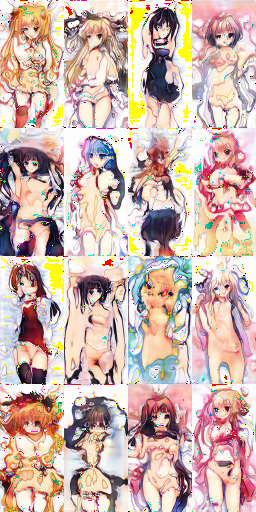

epoch 9,  g_loss: -12.569481, d_loss: 0.146995, alpha: 1.000000, depth: 5
epoch 10,  g_loss: 4.845162, d_loss: -3.514258, alpha: 1.000000, depth: 5
epoch 11,  g_loss: -3.969013, d_loss: -1.592599, alpha: 1.000000, depth: 5
193 / 226

epoch 12,  g_loss: 0.265156, d_loss: -0.819975, alpha: 1.000000, depth: 5
epoch 13,  g_loss: -5.774836, d_loss: -3.557709, alpha: 1.000000, depth: 5
epoch 14,  g_loss: -0.354869, d_loss: 0.394644, alpha: 1.000000, depth: 5
191 / 226

epoch 15,  g_loss: -6.615707, d_loss: 0.401201, alpha: 1.000000, depth: 5
epoch 16,  g_loss: 4.281102, d_loss: -2.140432, alpha: 1.000000, depth: 5
epoch 17,  g_loss: 4.261813, d_loss: -4.049739, alpha: 1.000000, depth: 5
193 / 226

epoch 18,  g_loss: 10.066526, d_loss: -3.250797, alpha: 1.000000, depth: 5
226 / 226

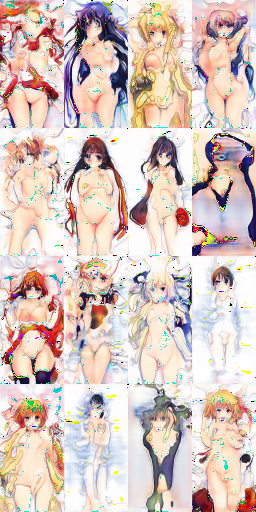

epoch 19,  g_loss: -8.038518, d_loss: 2.000751, alpha: 1.000000, depth: 5
epoch 20,  g_loss: 17.380753, d_loss: -0.019851, alpha: 1.000000, depth: 5
epoch 21,  g_loss: 5.568452, d_loss: -3.832781, alpha: 1.000000, depth: 5
192 / 226

epoch 22,  g_loss: 6.023674, d_loss: -1.366463, alpha: 1.000000, depth: 5
epoch 23,  g_loss: 3.558970, d_loss: -0.848456, alpha: 1.000000, depth: 5
epoch 24,  g_loss: 3.412670, d_loss: -1.321864, alpha: 1.000000, depth: 5
193 / 226

epoch 25,  g_loss: -7.302286, d_loss: -2.669683, alpha: 1.000000, depth: 5
epoch 26,  g_loss: 3.983021, d_loss: -1.824751, alpha: 1.000000, depth: 5
epoch 27,  g_loss: -13.380157, d_loss: -2.525404, alpha: 1.000000, depth: 5
188 / 226

epoch 28,  g_loss: -2.755363, d_loss: -0.314458, alpha: 1.000000, depth: 5
226 / 226

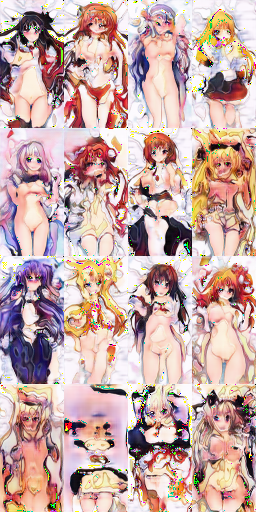

epoch 29,  g_loss: -9.241888, d_loss: -1.036606, alpha: 1.000000, depth: 5
epoch 30,  g_loss: 5.533340, d_loss: -1.006692, alpha: 1.000000, depth: 5
epoch 31,  g_loss: -2.362535, d_loss: -1.376204, alpha: 1.000000, depth: 5
190 / 226

epoch 32,  g_loss: -7.300083, d_loss: 1.191141, alpha: 1.000000, depth: 5
epoch 33,  g_loss: -0.133461, d_loss: -2.656427, alpha: 1.000000, depth: 5
epoch 34,  g_loss: -4.167535, d_loss: -1.260537, alpha: 1.000000, depth: 5
190 / 226

epoch 35,  g_loss: 3.446673, d_loss: -0.841184, alpha: 1.000000, depth: 5
epoch 36,  g_loss: 4.184376, d_loss: -3.238651, alpha: 1.000000, depth: 5
epoch 37,  g_loss: -1.589451, d_loss: -3.892220, alpha: 1.000000, depth: 5
192 / 226

epoch 38,  g_loss: -0.253089, d_loss: -1.956507, alpha: 1.000000, depth: 5
226 / 226

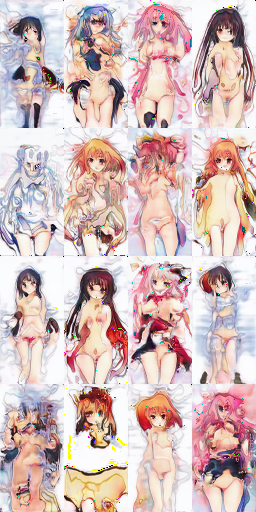

epoch 39,  g_loss: -7.800323, d_loss: 0.426568, alpha: 1.000000, depth: 5
epoch 40,  g_loss: 2.063474, d_loss: -1.277781, alpha: 1.000000, depth: 5
epoch 41,  g_loss: 8.173751, d_loss: -3.907294, alpha: 1.000000, depth: 5
194 / 226

epoch 42,  g_loss: -2.030637, d_loss: -0.295391, alpha: 1.000000, depth: 5
epoch 43,  g_loss: -7.544981, d_loss: -0.790176, alpha: 1.000000, depth: 5
epoch 44,  g_loss: -10.929592, d_loss: 0.542096, alpha: 1.000000, depth: 5
187 / 226

epoch 45,  g_loss: -6.862024, d_loss: 0.708608, alpha: 1.000000, depth: 5
epoch 46,  g_loss: -15.433680, d_loss: -2.660026, alpha: 1.000000, depth: 5
epoch 47,  g_loss: -12.587513, d_loss: 3.204635, alpha: 1.000000, depth: 5
188 / 226

epoch 48,  g_loss: -4.480097, d_loss: 3.255598, alpha: 1.000000, depth: 5
226 / 226

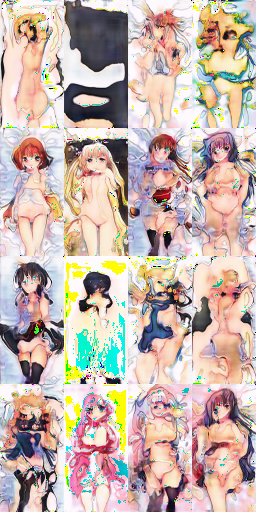

epoch 49,  g_loss: 3.610857, d_loss: -5.746096, alpha: 1.000000, depth: 5
epoch 50,  g_loss: -4.405780, d_loss: -5.072670, alpha: 1.000000, depth: 5
epoch 51,  g_loss: -7.665257, d_loss: -1.389055, alpha: 1.000000, depth: 5
191 / 226

epoch 52,  g_loss: 11.330116, d_loss: -1.393782, alpha: 1.000000, depth: 5
epoch 53,  g_loss: -0.287614, d_loss: -1.897752, alpha: 1.000000, depth: 5
epoch 54,  g_loss: -5.877993, d_loss: 0.583577, alpha: 1.000000, depth: 5
188 / 226

epoch 55,  g_loss: -2.286114, d_loss: -2.930009, alpha: 1.000000, depth: 5
epoch 56,  g_loss: -3.815158, d_loss: -0.534344, alpha: 1.000000, depth: 5
epoch 57,  g_loss: -6.378539, d_loss: -2.666235, alpha: 1.000000, depth: 5
187 / 226

epoch 58,  g_loss: -6.433466, d_loss: -0.900807, alpha: 1.000000, depth: 5
226 / 226

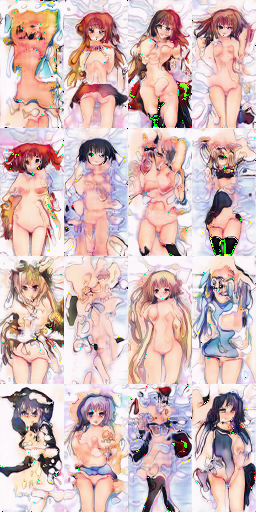

epoch 59,  g_loss: -23.862350, d_loss: -2.678809, alpha: 1.000000, depth: 5
epoch 60,  g_loss: -10.048629, d_loss: 2.528972, alpha: 1.000000, depth: 5
epoch 61,  g_loss: -8.965203, d_loss: -1.937458, alpha: 1.000000, depth: 5
186 / 226

epoch 62,  g_loss: -12.662861, d_loss: -0.174414, alpha: 1.000000, depth: 5
epoch 63,  g_loss: -2.120777, d_loss: -4.612672, alpha: 1.000000, depth: 5
epoch 64,  g_loss: -9.621155, d_loss: -1.308036, alpha: 1.000000, depth: 5
184 / 226

epoch 65,  g_loss: -4.405734, d_loss: -1.692590, alpha: 1.000000, depth: 5
epoch 66,  g_loss: 3.934497, d_loss: -0.901939, alpha: 1.000000, depth: 5
epoch 67,  g_loss: 2.469346, d_loss: -3.528064, alpha: 1.000000, depth: 5
190 / 226

epoch 68,  g_loss: 0.702203, d_loss: -1.032249, alpha: 1.000000, depth: 5
226 / 226

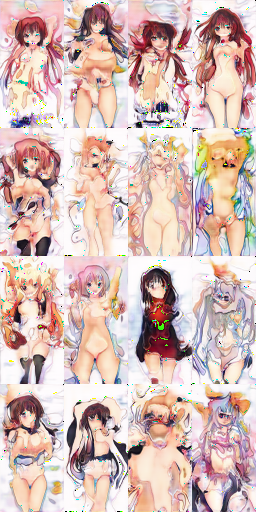

epoch 69,  g_loss: -11.036860, d_loss: -0.737102, alpha: 1.000000, depth: 5
epoch 70,  g_loss: 1.255040, d_loss: -2.578025, alpha: 1.000000, depth: 5
epoch 71,  g_loss: -13.778902, d_loss: -2.404540, alpha: 1.000000, depth: 5
187 / 226

epoch 72,  g_loss: -6.874317, d_loss: 2.698684, alpha: 1.000000, depth: 5
epoch 73,  g_loss: -6.626746, d_loss: -2.205200, alpha: 1.000000, depth: 5
epoch 74,  g_loss: 0.078761, d_loss: -2.308318, alpha: 1.000000, depth: 5
191 / 226

epoch 75,  g_loss: -3.364025, d_loss: 0.111159, alpha: 1.000000, depth: 5
epoch 76,  g_loss: -9.156098, d_loss: -3.715954, alpha: 1.000000, depth: 5
epoch 77,  g_loss: -11.632423, d_loss: -0.758091, alpha: 1.000000, depth: 5
189 / 226

epoch 78,  g_loss: -8.955012, d_loss: 4.507808, alpha: 1.000000, depth: 5
226 / 226

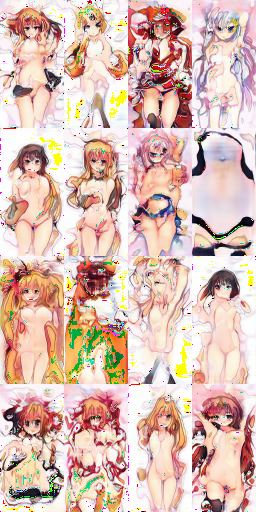

epoch 79,  g_loss: 5.871479, d_loss: -3.435949, alpha: 1.000000, depth: 5
epoch 80,  g_loss: -7.358332, d_loss: -1.045509, alpha: 1.000000, depth: 5
epoch 81,  g_loss: 3.881179, d_loss: -3.219073, alpha: 1.000000, depth: 5
192 / 226

epoch 82,  g_loss: -8.743221, d_loss: 1.446175, alpha: 1.000000, depth: 5
epoch 83,  g_loss: -4.182028, d_loss: -1.241333, alpha: 1.000000, depth: 5
epoch 84,  g_loss: -1.004230, d_loss: -2.696382, alpha: 1.000000, depth: 5
190 / 226

epoch 85,  g_loss: -1.202553, d_loss: -0.679283, alpha: 1.000000, depth: 5
epoch 86,  g_loss: -13.117277, d_loss: -0.192264, alpha: 1.000000, depth: 5
epoch 87,  g_loss: -5.528049, d_loss: -0.790672, alpha: 1.000000, depth: 5
185 / 226

epoch 88,  g_loss: -14.399882, d_loss: -0.684657, alpha: 1.000000, depth: 5
226 / 226

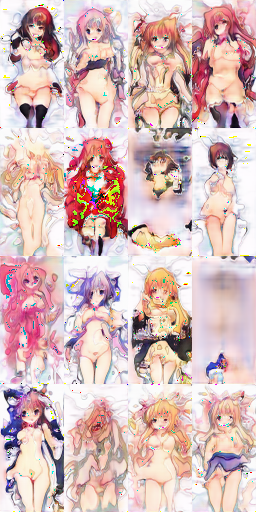

epoch 89,  g_loss: -5.848757, d_loss: -3.683989, alpha: 1.000000, depth: 5
epoch 90,  g_loss: -0.518157, d_loss: -6.168158, alpha: 1.000000, depth: 5
epoch 91,  g_loss: 8.139481, d_loss: -2.000020, alpha: 1.000000, depth: 5
189 / 226

epoch 92,  g_loss: -5.918973, d_loss: -1.663112, alpha: 1.000000, depth: 5
epoch 93,  g_loss: -5.791429, d_loss: -3.095357, alpha: 1.000000, depth: 5
epoch 94,  g_loss: -15.147854, d_loss: -3.911711, alpha: 1.000000, depth: 5
186 / 226

epoch 95,  g_loss: -8.679686, d_loss: -0.471759, alpha: 1.000000, depth: 5
epoch 96,  g_loss: 1.535711, d_loss: -0.479686, alpha: 1.000000, depth: 5
epoch 97,  g_loss: -5.909240, d_loss: -1.932332, alpha: 1.000000, depth: 5
189 / 226

epoch 98,  g_loss: -1.191751, d_loss: 0.177172, alpha: 1.000000, depth: 5
226 / 226

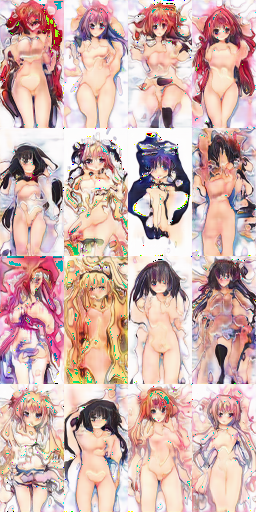

epoch 99,  g_loss: -5.583439, d_loss: 0.064365, alpha: 1.000000, depth: 5
epoch 100,  g_loss: 12.879541, d_loss: -3.193751, alpha: 1.000000, depth: 5
epoch 101,  g_loss: 2.100784, d_loss: -2.338983, alpha: 1.000000, depth: 5
190 / 226

epoch 102,  g_loss: 0.138579, d_loss: -4.286718, alpha: 1.000000, depth: 5
epoch 103,  g_loss: -7.405033, d_loss: -2.449005, alpha: 1.000000, depth: 5
epoch 104,  g_loss: 4.342409, d_loss: -1.499543, alpha: 1.000000, depth: 5
185 / 226

epoch 105,  g_loss: -7.030012, d_loss: -4.133629, alpha: 1.000000, depth: 5
epoch 106,  g_loss: 5.945662, d_loss: -2.375771, alpha: 1.000000, depth: 5
epoch 107,  g_loss: 1.066541, d_loss: -5.371265, alpha: 1.000000, depth: 5
184 / 226

epoch 108,  g_loss: -15.998411, d_loss: -1.987458, alpha: 1.000000, depth: 5
226 / 226

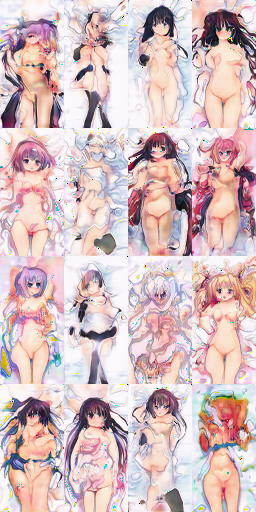

epoch 109,  g_loss: -0.091187, d_loss: -1.996542, alpha: 1.000000, depth: 5
epoch 110,  g_loss: -8.826454, d_loss: 0.578370, alpha: 1.000000, depth: 5
epoch 111,  g_loss: -11.579952, d_loss: -1.592722, alpha: 1.000000, depth: 5
184 / 226

epoch 112,  g_loss: -1.650335, d_loss: -3.257042, alpha: 1.000000, depth: 5
epoch 113,  g_loss: -1.834297, d_loss: -2.218863, alpha: 1.000000, depth: 5
epoch 114,  g_loss: -1.120711, d_loss: -0.977934, alpha: 1.000000, depth: 5
182 / 226

epoch 115,  g_loss: -7.370077, d_loss: 1.309429, alpha: 1.000000, depth: 5
epoch 116,  g_loss: -1.536694, d_loss: 0.131249, alpha: 1.000000, depth: 5
epoch 117,  g_loss: -6.242503, d_loss: 0.375354, alpha: 1.000000, depth: 5
187 / 226

epoch 118,  g_loss: -2.069373, d_loss: -5.026948, alpha: 1.000000, depth: 5
226 / 226

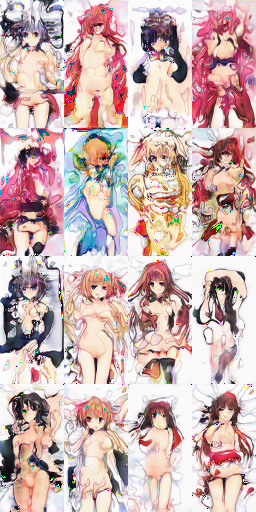

epoch 119,  g_loss: 2.064838, d_loss: -3.105964, alpha: 1.000000, depth: 5
epoch 120,  g_loss: 0.200264, d_loss: -1.606799, alpha: 1.000000, depth: 5
epoch 121,  g_loss: -6.486699, d_loss: -0.014312, alpha: 1.000000, depth: 5
188 / 226

epoch 122,  g_loss: -10.011415, d_loss: -2.142476, alpha: 1.000000, depth: 5
epoch 123,  g_loss: 5.332222, d_loss: -0.935254, alpha: 1.000000, depth: 5
epoch 124,  g_loss: -6.013816, d_loss: 0.629421, alpha: 1.000000, depth: 5
182 / 226

epoch 125,  g_loss: 9.306031, d_loss: -5.182922, alpha: 1.000000, depth: 5
epoch 126,  g_loss: -0.750775, d_loss: 0.414413, alpha: 1.000000, depth: 5
epoch 127,  g_loss: 8.307811, d_loss: -1.971215, alpha: 1.000000, depth: 5
187 / 226

epoch 128,  g_loss: 1.346652, d_loss: -1.330806, alpha: 1.000000, depth: 5
226 / 226

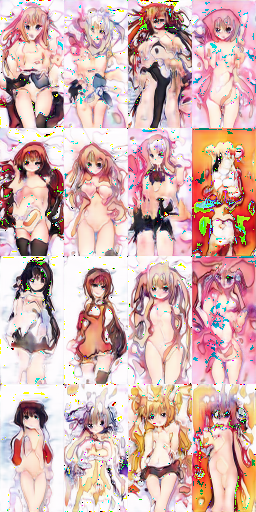

epoch 129,  g_loss: -2.839121, d_loss: 0.645177, alpha: 1.000000, depth: 5
epoch 130,  g_loss: -6.480103, d_loss: -2.305400, alpha: 1.000000, depth: 5
epoch 131,  g_loss: -18.668667, d_loss: 1.266800, alpha: 1.000000, depth: 5
186 / 226

epoch 132,  g_loss: 10.151687, d_loss: -3.033310, alpha: 1.000000, depth: 5
epoch 133,  g_loss: 15.512691, d_loss: -6.664083, alpha: 1.000000, depth: 5
epoch 134,  g_loss: -12.213151, d_loss: -1.273215, alpha: 1.000000, depth: 5
181 / 226

epoch 135,  g_loss: -8.717849, d_loss: -1.525409, alpha: 1.000000, depth: 5
epoch 136,  g_loss: 6.445192, d_loss: -3.417895, alpha: 1.000000, depth: 5
epoch 137,  g_loss: 0.139598, d_loss: -0.684438, alpha: 1.000000, depth: 5
184 / 226

epoch 138,  g_loss: 2.603208, d_loss: -2.489439, alpha: 1.000000, depth: 5
226 / 226

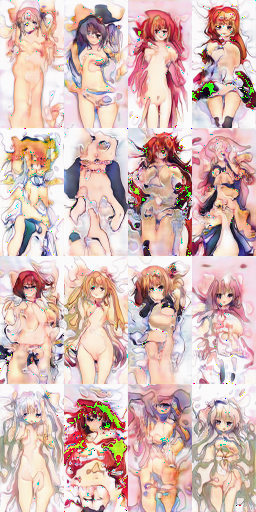

epoch 139,  g_loss: -13.777740, d_loss: -1.210564, alpha: 1.000000, depth: 5
epoch 140,  g_loss: -9.421713, d_loss: -2.694554, alpha: 1.000000, depth: 5
epoch 141,  g_loss: -5.269812, d_loss: -0.530504, alpha: 1.000000, depth: 5
181 / 226

epoch 142,  g_loss: -0.507774, d_loss: -4.553370, alpha: 1.000000, depth: 5
epoch 143,  g_loss: 0.624872, d_loss: -3.148546, alpha: 1.000000, depth: 5
epoch 144,  g_loss: -6.508360, d_loss: -0.441916, alpha: 1.000000, depth: 5
183 / 226

epoch 145,  g_loss: -0.293610, d_loss: 2.108481, alpha: 1.000000, depth: 5
epoch 146,  g_loss: 1.614719, d_loss: -3.724580, alpha: 1.000000, depth: 5
epoch 147,  g_loss: -2.471035, d_loss: 0.655518, alpha: 1.000000, depth: 5
72 / 226

In [0]:
#training
#BATCH_SIZE = 32
#train(depth=0, start_alpha=0, g_learn_rate = 0.001, d_learn_rate = 0.001, gp_rate = 10)#4*4
#train(depth=1, start_alpha=0, g_learn_rate = 0.0008, d_learn_rate = 0.0008, gp_rate = 10)#8*8
#train(depth=2, start_alpha=0, g_learn_rate = 0.00064, d_learn_rate = 0.00064, gp_rate = 10)#16*16#
#BATCH_SIZE = 24
#train(depth=3, start_alpha=0, g_learn_rate = 0.0005, d_learn_rate = 0.0005, gp_rate = 10)#32*32
#train(depth=4, start_alpha=0, g_learn_rate = 0.0004, d_learn_rate = 0.0004, gp_rate = 10)#64*64
BATCH_SIZE = 16
train(depth=5, start_alpha=1, g_learn_rate = 0.001, d_learn_rate = 0.001, gp_rate = 10)#128*128
BATCH_SIZE = 8
#train(depth=6, start_alpha=0, g_learn_rate = 0.00025, d_learn_rate = 0.00025, gp_rate = 10)#256*256